In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import category_encoders as ce

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

# Utility
import os
import time
import datetime
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
international_trade = pd.read_csv('../data/international_trade.csv')
train.drop(columns = 'ID', inplace = True)
test.drop(columns = 'ID', inplace = True)

In [3]:
train = train.rename(columns={'supply(kg)':'supply','price(원/kg)':'price'})
train.columns

Index(['timestamp', 'item', 'corporation', 'location', 'supply', 'price'], dtype='object')

In [4]:
# 시계열 데이터 처리
train.timestamp = pd.to_datetime(train.timestamp)
test.timestamp = pd.to_datetime(test.timestamp)

########### test 데이터 supply 컬럼 추가
test['supply'] = np.zeros((len(test),1))
def find_lastyear_supply(row):
    # date1 : 1년 전 같은 datetime
    date1 = pd.to_datetime(f'{row["timestamp"].year-1}-{row["timestamp"].month}-{row["timestamp"].day}').date()
    # date2 : 2년 전 같은 datetime
    date2 = pd.to_datetime(f'{row["timestamp"].year-2}-{row["timestamp"].month}-{row["timestamp"].day}').date()
#     print(date)
    # 1,2년 전 같은 날짜 & 유통업체 & 지역 & 품목의 supply 평균값으로 test에 supply컬럼 추가
    row['supply'] = train[((train['timestamp'].dt.date==date1)|(train['timestamp'].dt.date==date2))&
                            (train['corporation']==row['corporation'])&
                            (train['location']==row['location']) &
                            (train['item']==row['item'])]['supply'].sum()
#     print(row['supply'])
    return row
test = test.apply(find_lastyear_supply,axis=1)
########### test 데이터 supply 컬럼 추가 -END-

# year
train['year'] = train.timestamp.dt.year
test['year'] = test.timestamp.dt.year

# month
train['month'] = train.timestamp.dt.month
test['month'] = test.timestamp.dt.month

# day
train['day'] = train.timestamp.dt.day
test['day'] = test.timestamp.dt.day

# week
train['week'] = train.timestamp.dt.dayofweek
test['week'] = test.timestamp.dt.dayofweek

# 주말여부
train['weekend'] = train.week.apply(lambda x : 1 if x in [5,6] else 0)
test['weekend'] = test.week.apply(lambda x : 1 if x in [5,6] else 0)

# date (월-일)
train['date'] = train.timestamp.apply(lambda x : int(str(x)[5:7] + str(x)[8:10]))
test['date'] = test.timestamp.apply(lambda x : int(str(x)[5:7] + str(x)[8:10]))

# year_month
train['year_month'] = train.timestamp.apply(lambda x : str(x)[0:7])
test['year_month'] = test.timestamp.apply(lambda x : str(x)[0:7])

In [5]:
# test에 supply 잘 들어갔는지 확인
print(test[(test['timestamp']=='2023-03-27')&(test['item']=='RD')&(test['corporation']=='F')&(test['location']=='J')]['supply'])
print(train[(train['timestamp']=='2021-03-27')&(train['item']=='RD')&(train['corporation']=='F')&(train['location']=='J')]['supply'])
print(train[(train['timestamp']=='2022-03-27')&(train['item']=='RD')&(train['corporation']=='F')&(train['location']=='J')]['supply'])

1087    296720.0
Name: supply, dtype: float64
58690    296720.0
Name: supply, dtype: float64
59055    0.0
Name: supply, dtype: float64


In [6]:
# Encoding 
encoders = {}
for col in ['item','corporation']:
    encoder = ce.TargetEncoder()
    train[col] = encoder.fit_transform(train[col],train['price'])
    test[col] = encoder.transform(test[col])
    encoders[col] = encoder

encoder = LabelEncoder()
train['location'] = encoder.fit_transform(train['location'])
test['location'] = encoder.transform(test['location'])
encoders['location'] = encoder

In [7]:
# drop unnecessary cols, define features and target
train_ = train.drop(columns = ['timestamp', 'year_month'])
test_ = test.drop(columns = ['timestamp', 'year_month'])
feature = train_.drop(columns=['supply','price']) # 피처에 supply 미포함
feature_te = test_.drop(columns=['supply']) # 피처에 supply 미포함
# feature = train_.drop(columns=['price']) # 피처에 supply 포함하는 버전
# feature_te = test_
target = train_.price

In [8]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

def get_MSE(feature,target):
    # MSE를 스코어링 함수로 정의
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    # LightGBM 모델 초기화
    model = lgb.LGBMRegressor(verbose = -1,force_col_wise = True)
    # force_col_wise = 메모리 이슈로 도중에 row-wise 탐색으로 바뀌는 것을 방지

    # 교차 검증 수행
    cross_val_scores = -cross_val_score(model, feature, target, cv=5, scoring=mse_scorer)
    rmse = np.sqrt(cross_val_scores)

    # 교차 검증 스코어 출력
    print("MAE scores for each fold:", rmse)  # Negative values are used because cross_val_score returns negated scores
    print("Mean MAE:", rmse.mean())

In [9]:
get_MSE(feature,target)

MAE scores for each fold: [2003.78342955 1082.28280031  381.24791795  601.36285585  943.10923828]
Mean MAE: 1002.357248388386


In [10]:
def lbgm_feature_importance(feature,target):
    # LightGBM 모델 초기화
    model = lgb.LGBMRegressor(verbose = 0,force_col_wise=True)

    # 모델을 학습 , 중요도 계산
    model.fit(feature, target)

    # 피쳐 중요도 가져오기
    feature_importance = model.feature_importances_

    # 중요도가 높은 상위 20개 피쳐 인덱스 가져오기
    top_20_feature_indices = feature_importance.argsort()[-25:][::-1]

    # 상위 20개 피쳐의 중요도 가져오기
    top_20_feature_importance = feature_importance[top_20_feature_indices]

    # 상위 20개 피쳐의 이름 가져오기
    top_20_feature_names = feature.columns[top_20_feature_indices]

    # 중요도 시각화
    plt.figure(figsize=(10, 6))
    plt.barh(top_20_feature_names, top_20_feature_importance)
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importance')
    plt.show()
    
    return top_20_feature_importance,top_20_feature_names

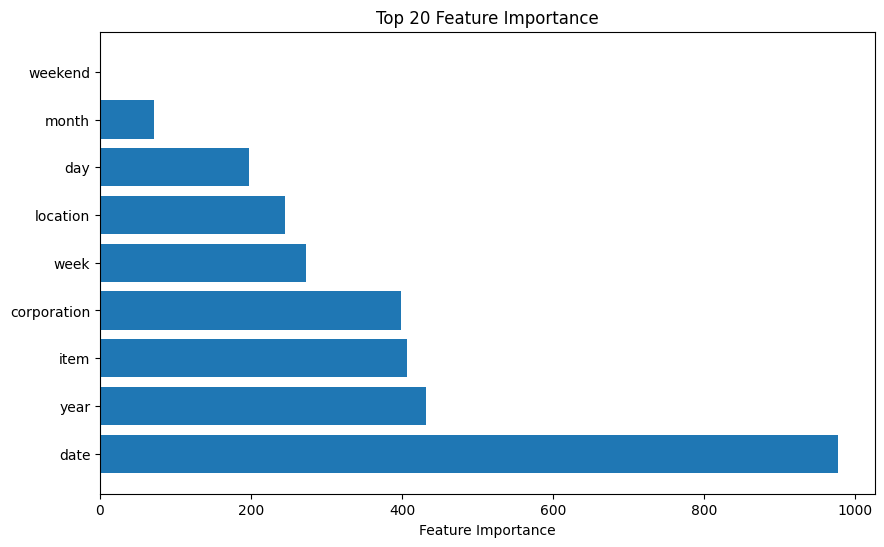

In [11]:
top_20_feature_importance,top_20_feature_names = lbgm_feature_importance(feature,target)

In [12]:
top_20_feature_importance, top_20_feature_names

(array([977, 431, 406, 398, 273, 245, 197,  72,   1]),
 Index(['date', 'year', 'item', 'corporation', 'week', 'location', 'day',
        'month', 'weekend'],
       dtype='object'))

In [13]:
# 피처 선택
# 2가지 버전 준비 
# 1. 피처 선택 버전
threshold = 150
low_importance_features_name = list(top_20_feature_names[np.where(top_20_feature_importance<150)[0]])
feature_selected = feature.drop(columns=low_importance_features_name)
feature_te_selected = feature_te.drop(columns=low_importance_features_name)
# 2. 모든 피처로 학습 >> feature, feature_te 그대로 사용

In [14]:
# 1. 피처 선택 버전 
# MSE 확인
get_MSE(feature_selected,target)
# 모델 학습 (아직 튜닝 미완료)
v1_lgbm_model = lgb.LGBMRegressor(force_col_wise=True)
v1_lgbm_model.fit(feature_selected,target)
v1_pred = v1_lgbm_model.predict(feature_te_selected)

MAE scores for each fold: [1994.73012672 1078.38556416  404.56709362  602.13347647  943.59073386]
Mean MAE: 1004.6813989666829


In [15]:
# 2. 피처 선택 버전 
# MSE 확인
get_MSE(feature,target)
# 모델 학습 (아직 튜닝 미완료)
v2_lgbm_model = lgb.LGBMRegressor(force_col_wise=True)
v2_lgbm_model.fit(feature,target)
v2_pred = v2_lgbm_model.predict(feature_te)

MAE scores for each fold: [2003.78342955 1082.28280031  381.24791795  601.36285585  943.10923828]
Mean MAE: 1002.357248388386


In [16]:
# sample_submission으로 저장하기
sample_submission = pd.read_csv('../data/sample_submission.csv')
sample_submission['answer']=np.where(v2_pred<0,0,v2_pred) # 혹시 음수값이 있을까봐 조건부로 입력
sample_submission.head()

,ID,answer
0,TG_A_J_20230304,3306.544286
1,TG_A_J_20230305,67.059075
2,TG_A_J_20230306,3508.097672
3,TG_A_J_20230307,3508.097672
4,TG_A_J_20230308,3511.295365


In [17]:
# save sample_submission
sample_submission.set_index('ID',inplace=True)
sample_submission.to_csv('../data/sample_20231103_2343.csv')

In [18]:
feature.columns

Index(['item', 'corporation', 'location', 'year', 'month', 'day', 'week',
       'weekend', 'date'],
      dtype='object')